## Modeling *[Risus](http://risus.cumberlandgames.com/)* in [``dyce``](https://posita.github.io/dyce/)

Select ``Run All Cells`` from the ``Run`` menu above.

 | Standard<br>(First Round) | LOSS | DRAW | WIN |
|:---:|:---:|:---:|:---:|
| 3d6 vs 3d6 | 45.36% | 9.28% | 45.36% |
| 4d6 vs 3d6 | 19.17% | 6.55% | 74.28% |
| 5d6 vs 3d6 | 6.07% | 2.99% | 90.93% |
 |  |  |  |  |
| 4d6 vs 4d6 | 45.95% | 8.09% | 45.95% |
| 5d6 vs 4d6 | 22.04% | 6.15% | 71.81% |
| 6d6 vs 4d6 | 8.34% | 3.26% | 88.40% |
 |  |  |  |  |
| 5d6 vs 5d6 | 46.37% | 7.27% | 46.37% |
| 6d6 vs 5d6 | 24.24% | 5.79% | 69.96% |
| 7d6 vs 5d6 | 10.36% | 3.40% | 86.24% |

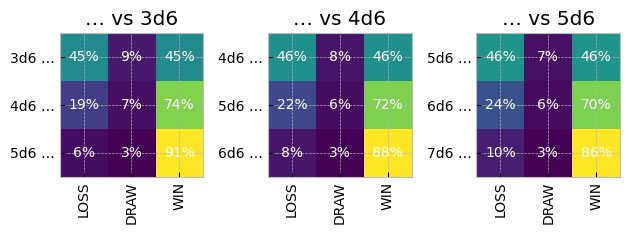

In [1]:
import matplotlib.pyplot
import matplotlib.style
from enum import IntEnum, auto
from IPython.display import display, Markdown
from dyce import H

class Risus(IntEnum):
    LOSS = -1
    DRAW = auto()
    WIN = auto()

distribution_fill = {e.value: 0 for e in Risus}

def heatmap(
    us_vs_them_func,
    start_d: int = 3,
    num_scenarios: int = 3,
    cmap = "viridis",
):
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    matplotlib.style.use("bmh")
    col_names = [e.name for e in Risus]
    col_ticks = list(range(len(Risus)))

    for i, them in enumerate(range(start_d, start_d + num_scenarios)):
        row_names = []
        rows = []
        num_rows = 3

        for us in range(them, them + num_rows):
            row_names.append(f"{us}d6 …")
            results = us_vs_them_func(us, them)
            rows.append(results.distribution_xy(distribution_fill)[-1])

        ax = matplotlib.pyplot.subplot(1, num_scenarios, i + 1)
        ax.imshow(rows, cmap=cmap)
        ax.set_title(f"… vs {them}d6")
        ax.set_xticks(col_ticks)
        ax.set_xticklabels(col_names, rotation=90)
        ax.set_yticks(list(range(len(rows))))
        ax.set_yticklabels(row_names)

        for y in range(len(row_names)):
            for x in col_ticks:
                ax.text(
                    x,
                    y,
                    f"{rows[y][x]:.0%}",
                    ha="center",
                    va="center",
                    color="w",
                )

    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

def md_table(
    challenge: str,
    us_vs_them_func,
    start_d: int = 3,
    num_scenarios: int = 3,
) -> str:
    def _md_table_rows():
        yield(f" | {challenge} | " + " | ".join(i.name for i in Risus) + " |")
        yield("|:---:|:---:|:---:|:---:|")
        for t in range(start_d, start_d + num_scenarios):
            for u in range(t, t + 3):
                results = us_vs_them_func(u, t)
                yield(f"| {u}d6 vs {t}d6 | " + " | ".join(f"{prob:0.2%}" for prob in results.distribution_xy(distribution_fill)[-1]) + " |")
            if t < start_d + num_scenarios - 1:
                yield(" |  | " + " | ".join("" for i in Risus) + " |")

    return display(Markdown("\n".join(_md_table_rows())))

us_vs_them_func = lambda u, t: (u @ H(6)).vs(t @ H(6))
md_table("Standard<br>(First Round)", us_vs_them_func)
heatmap(us_vs_them_func)

In [2]:
import sys

if sys.version_info >= (3, 9):
    from functools import cache
else:
    from functools import lru_cache
    cache = lru_cache(maxsize=None)

def risus_combat_driver(
    us: int,  # number of dice we still have
    them: int,  # number of dice they still have
    us_vs_them_func,
) -> H:
    if us < 0 or them < 0:
        raise ValueError(f"cannot have negative numbers (us: {us}, them: {them})")
    if us == 0 and them == 0:
        return H(
            {Risus.DRAW: 1}
        )  # should not happen unless combat(0, 0) is called from the start

    @cache
    def _resolve(us: int, them: int) -> H:
        if us == 0:
            return H({Risus.LOSS: 1})  # we are out of dice, they win
        if them == 0:
            return H({Risus.WIN: 1})  # they are out of dice, we win
        this_round = us_vs_them_func(us, them)

        def _next_round(this_round_outcome) -> H:
            if this_round_outcome == Risus.LOSS:
                return _resolve(us - 1, them)  # we lost this round, and one die
            elif this_round_outcome == Risus.WIN:
                return _resolve(us, them - 1)  # they lost this round, and one die
            elif this_round_outcome == Risus.DRAW:
                return H({})  # ignore (immediately re-roll) all ties
            else:
                assert False, f"unrecognized outcome {outcome}"

        return H.foreach(_next_round, this_round_outcome=this_round)

    return _resolve(us, them)

 | Standard<br>(Complete Combat) | LOSS | DRAW | WIN |
|:---:|:---:|:---:|:---:|
| 3d6 vs 3d6 | 50.00% | 0.00% | 50.00% |
| 4d6 vs 3d6 | 10.50% | 0.00% | 89.50% |
| 5d6 vs 3d6 | 0.66% | 0.00% | 99.34% |
 |  |  |  |  |
| 4d6 vs 4d6 | 50.00% | 0.00% | 50.00% |
| 5d6 vs 4d6 | 12.25% | 0.00% | 87.75% |
| 6d6 vs 4d6 | 1.07% | 0.00% | 98.93% |
 |  |  |  |  |
| 5d6 vs 5d6 | 50.00% | 0.00% | 50.00% |
| 6d6 vs 5d6 | 13.66% | 0.00% | 86.34% |
| 7d6 vs 5d6 | 1.49% | 0.00% | 98.51% |

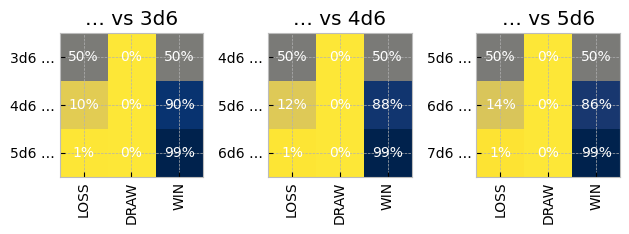

In [3]:
from functools import partial

us_vs_them_func = partial(risus_combat_driver, us_vs_them_func = lambda u, t: (u @ H(6)).vs(t @ H(6)))
md_table("Standard<br>(Complete Combat)", us_vs_them_func)
heatmap(us_vs_them_func, cmap="cividis_r")

 | Deadly w/ Goliath Rule<br>(Complete Combat) | LOSS | DRAW | WIN |
|:---:|:---:|:---:|:---:|
| 4d6 vs 4d6 | 50.00% | 0.00% | 50.00% |
| 5d6 vs 4d6 | 40.67% | 0.00% | 59.33% |
| 6d6 vs 4d6 | 30.59% | 0.00% | 69.41% |
 |  |  |  |  |
| 5d6 vs 5d6 | 50.00% | 0.00% | 50.00% |
| 6d6 vs 5d6 | 44.13% | 0.00% | 55.87% |
| 7d6 vs 5d6 | 36.89% | 0.00% | 63.11% |
 |  |  |  |  |
| 6d6 vs 6d6 | 50.00% | 0.00% | 50.00% |
| 7d6 vs 6d6 | 46.57% | 0.00% | 53.43% |
| 8d6 vs 6d6 | 41.83% | 0.00% | 58.17% |
 |  |  |  |  |
| 7d6 vs 7d6 | 50.00% | 0.00% | 50.00% |
| 8d6 vs 7d6 | 48.16% | 0.00% | 51.84% |
| 9d6 vs 7d6 | 45.36% | 0.00% | 54.64% |

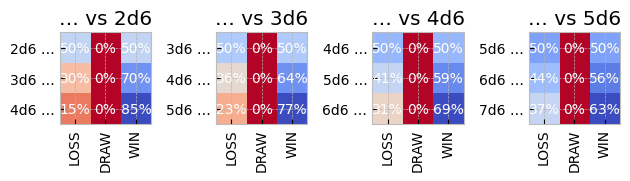

In [4]:
from dyce import P

def deadly_combat_vs(us: int, them: int) -> H:
    best_us = (us @ P(6)).h(-1)
    best_them = (them @ P(6)).h(-1)
    h = best_us.vs(best_them)
    # Goliath Rule: tie goes to the party with fewer dice in this round
    h = H.foreach(
        lambda outcome: (us < them) - (us > them) if outcome == 0 else outcome,
        outcome=h,
    )
    return h

us_vs_them_func = partial(risus_combat_driver, us_vs_them_func = deadly_combat_vs)
md_table("Deadly w/ Goliath Rule<br>(Complete Combat)", us_vs_them_func, start_d=4, num_scenarios=4)
heatmap(us_vs_them_func, start_d=2, num_scenarios=4, cmap="coolwarm_r")